### **Project: Self Supervised learning for image classification**
***Team members: Sri Gayathri Sahithi Morapakala, Sai Venkata Aditya Arepalli***

### **DINO self-distillation with no labels**

In [ ]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader,Subset
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

In [ ]:
from transformers import ViTMSNForImageClassification

In [ ]:
# Load the pre-trained model and feature extractor
model = AutoModelForImageClassification.from_pretrained("facebook/dino-vits16")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/dino-vits16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Modify the output layer to match the number of classes in CIFAR-10
num_classes = 10
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

In [ ]:
# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

In [ ]:
# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
full_test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 28598031.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create a subset of the training dataset (3000 images per class)
train_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_train_dataset.targets) if label == class_idx]
    train_subset_indices.extend(class_indices[:3000])

In [ ]:
train_dataset = Subset(full_train_dataset, train_subset_indices)

In [ ]:
# Create a subset of the test dataset (500 images per class)
test_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_test_dataset.targets) if label == class_idx]
    test_subset_indices.extend(class_indices[:500])

test_dataset = Subset(full_test_dataset, test_subset_indices)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.classifier = model.classifier.to(device)  # Move the new output layer to the device
print(device)

cuda


In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Hyperparameters
num_epochs = 20
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# Training loop
train_accuracies = []
train_top3_accuracies = []
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    top3_correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Top-3 accuracy
        _, top3_predicted = outputs.logits.topk(3, dim=1)
        top3_predicted = top3_predicted.t()
        correct_per_batch = (top3_predicted == labels.view(1, -1)).float().sum(dim=0)
        top3_correct += correct_per_batch.sum().item()

    lr_scheduler.step()  # Update the learning rate
    train_acc = 100 * correct / total
    train_top3_acc = 100 * top3_correct / total
    train_accuracies.append(train_acc)
    train_top3_accuracies.append(train_top3_acc)
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_acc:.2f}%, Train Top-3 Accuracy: {train_top3_acc:.2f}%")

Epoch 1/20, Loss: 2.295743283305341, Train Accuracy: 20.23%, Train Top-3 Accuracy: 50.69%
Epoch 2/20, Loss: 2.0118188265798445, Train Accuracy: 24.37%, Train Top-3 Accuracy: 59.06%
Epoch 3/20, Loss: 2.0135565283201906, Train Accuracy: 24.34%, Train Top-3 Accuracy: 58.58%
Epoch 4/20, Loss: 1.8844900490886876, Train Accuracy: 29.64%, Train Top-3 Accuracy: 64.62%
Epoch 5/20, Loss: 1.8380847962172047, Train Accuracy: 31.51%, Train Top-3 Accuracy: 66.89%
Epoch 6/20, Loss: 1.7846308022673958, Train Accuracy: 33.47%, Train Top-3 Accuracy: 69.12%
Epoch 7/20, Loss: 1.7344107236435164, Train Accuracy: 35.52%, Train Top-3 Accuracy: 70.76%
Epoch 8/20, Loss: 1.7153013753992663, Train Accuracy: 36.19%, Train Top-3 Accuracy: 71.47%
Epoch 9/20, Loss: 1.7019334680744325, Train Accuracy: 36.67%, Train Top-3 Accuracy: 71.92%
Epoch 10/20, Loss: 1.689247697782415, Train Accuracy: 37.06%, Train Top-3 Accuracy: 72.35%
Epoch 11/20, Loss: 1.6858074264739877, Train Accuracy: 37.16%, Train Top-3 Accuracy: 72.48%

In [ ]:
# Evaluation
model.eval()
#test_accuracies = [0] * num_epochs  # Initialize with num_epochs elements
#test_top3_accuracies = [0] * num_epochs  # Initialize with num_epochs elements
test_accuracies = []
test_top3_accuracies = []
test_losses = []
test_loss = 0.0
with torch.no_grad():
    correct = 0
    top3_correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()

        # Top-3 accuracy
        _, top3_predicted = outputs.logits.topk(3, dim=1)
        top3_predicted = top3_predicted.t()
        correct_per_batch = (top3_predicted == labels.view(1, -1)).float().sum(dim=0)
        top3_correct += correct_per_batch.sum().item()

    accuracy = 100 * correct / total
    top3_accuracy = 100 * top3_correct / total
    test_accuracies.append(accuracy)
    test_top3_accuracies.append(top3_accuracy)
    test_losses.append(test_loss / len(test_loader))
    print(f"Accuracy on test set: {accuracy:.2f}%, Top-3 Accuracy on test set: {top3_accuracy:.2f}%")

Accuracy on test set: 36.54%, Top-3 Accuracy on test set: 71.86%


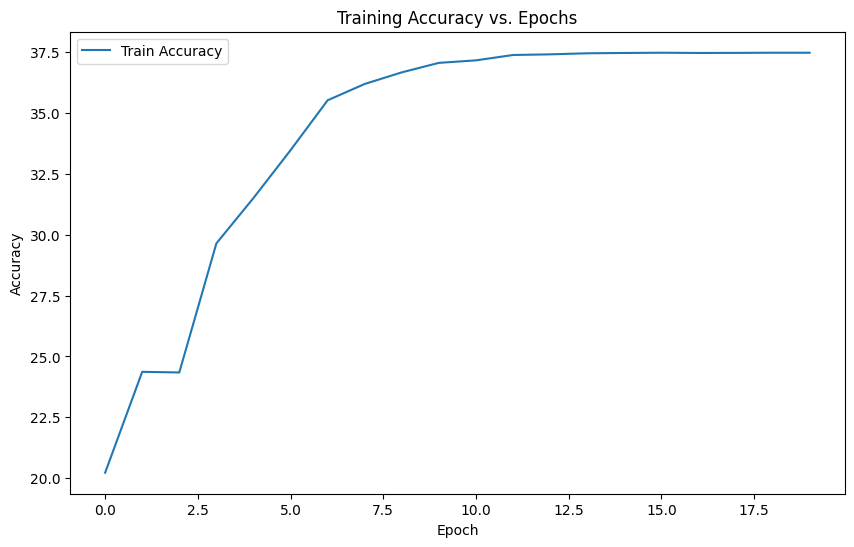

In [ ]:
# Plot accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.show()

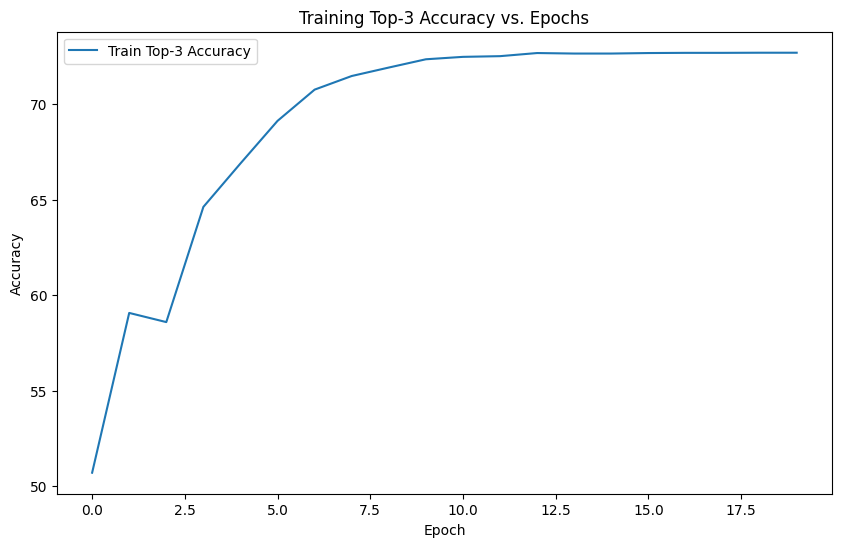

In [ ]:
# Plot top-3 accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_top3_accuracies, label='Train Top-3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Top-3 Accuracy vs. Epochs')
plt.legend()
plt.show()

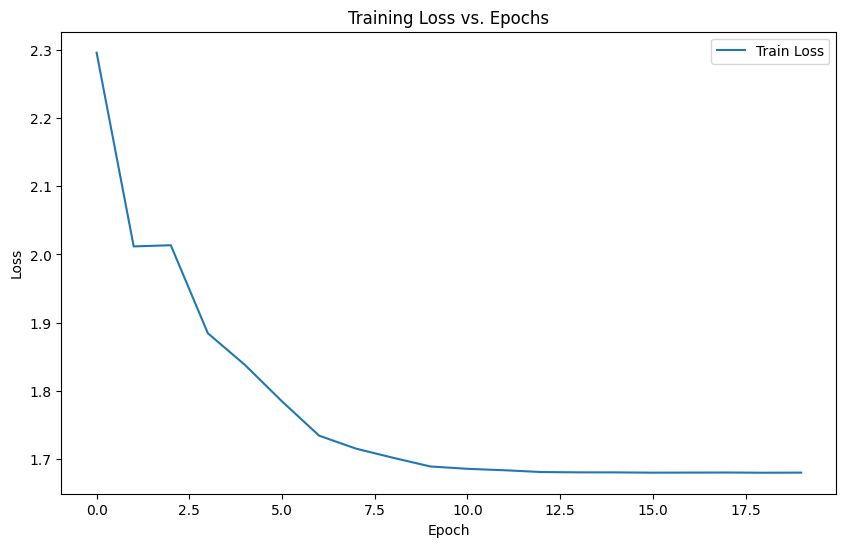

In [ ]:
# Plot training loss and test loss, accuracy, and top-3 accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()

###Data Augmentation



In [ ]:
# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to match the model's input size
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontally flip images with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Vertically flip images with a probability of 0.5
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply color jitter
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
    transforms.RandomRotation(60)
])

# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
full_test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Create a subset of the training dataset (10 images per class)
train_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_train_dataset.targets) if label == class_idx]
    train_subset_indices.extend(class_indices[:2000])
train_dataset = Subset(full_train_dataset, train_subset_indices)

# Create a subset of the test dataset (10 images per class)
test_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_test_dataset.targets) if label == class_idx]
    test_subset_indices.extend(class_indices[:500])

test_dataset = Subset(full_test_dataset, test_subset_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.classifier = model.classifier.to(device)  # Move the new output layer to the device

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

100%|██████████| 170498071/170498071 [00:01<00:00, 89348199.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Hyperparameters
num_epochs = 10
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
train_accuracies = []
train_top3_accuracies = []
train_losses = []
print('Performing training after data augmentation')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    top3_correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Top-3 accuracy
        _, top3_predicted = outputs.logits.topk(3, dim=1)
        top3_predicted = top3_predicted.t()
        correct_per_batch = (top3_predicted == labels.view(1, -1)).float().sum(dim=0)
        top3_correct += correct_per_batch.sum().item()

    lr_scheduler.step()  # Update the learning rate
    train_acc = 100 * correct / total
    train_top3_acc = 100 * top3_correct / total
    train_accuracies.append(train_acc)
    train_top3_accuracies.append(train_top3_acc)
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_acc:.2f}%, Train Top-3 Accuracy: {train_top3_acc:.2f}%")

Performing training after data augmentation
Epoch 1/10, Loss: 2.492025020980835, Train Accuracy: 15.93%, Train Top-3 Accuracy: 42.70%
Epoch 2/10, Loss: 2.152587829399109, Train Accuracy: 19.18%, Train Top-3 Accuracy: 51.57%
Epoch 3/10, Loss: 2.11371941242218, Train Accuracy: 20.43%, Train Top-3 Accuracy: 52.22%
Epoch 4/10, Loss: 2.0312799846649168, Train Accuracy: 23.05%, Train Top-3 Accuracy: 57.32%
Epoch 5/10, Loss: 2.009082677268982, Train Accuracy: 24.88%, Train Top-3 Accuracy: 58.08%
Epoch 6/10, Loss: 1.997692774772644, Train Accuracy: 24.52%, Train Top-3 Accuracy: 58.76%
Epoch 7/10, Loss: 1.979497633934021, Train Accuracy: 26.36%, Train Top-3 Accuracy: 60.08%
Epoch 8/10, Loss: 1.9740049423217774, Train Accuracy: 26.32%, Train Top-3 Accuracy: 60.68%
Epoch 9/10, Loss: 1.9714544122695923, Train Accuracy: 26.23%, Train Top-3 Accuracy: 60.69%
Epoch 10/10, Loss: 1.9637677383422851, Train Accuracy: 26.98%, Train Top-3 Accuracy: 61.12%


In [ ]:
# Evaluation
model.eval()
test_accuracies = []
test_top3_accuracies = []
test_losses = []
test_loss = 0.0
with torch.no_grad():
    correct = 0
    top3_correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()

        # Top-3 accuracy
        _, top3_predicted = outputs.logits.topk(3, dim=1)
        top3_predicted = top3_predicted.t()
        correct_per_batch = (top3_predicted == labels.view(1, -1)).float().sum(dim=0)
        top3_correct += correct_per_batch.sum().item()

    accuracy = 100 * correct / total
    top3_accuracy = 100 * top3_correct / total
    test_accuracies.append(accuracy)
    test_top3_accuracies.append(top3_accuracy)
    test_losses.append(test_loss / len(test_loader))
    print(f"Accuracy on data augmented test set: {accuracy:.2f}%, Top-3 Accuracy on test set: {top3_accuracy:.2f}%")

Accuracy on data augmented test set: 28.34%, Top-3 Accuracy on test set: 61.74%


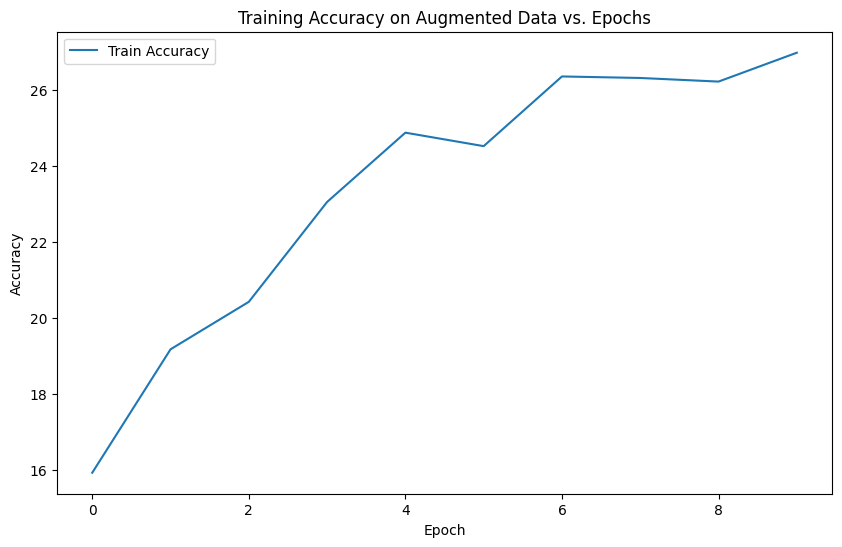

In [ ]:
# Plot accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy on Augmented Data vs. Epochs')
plt.legend()
plt.show()

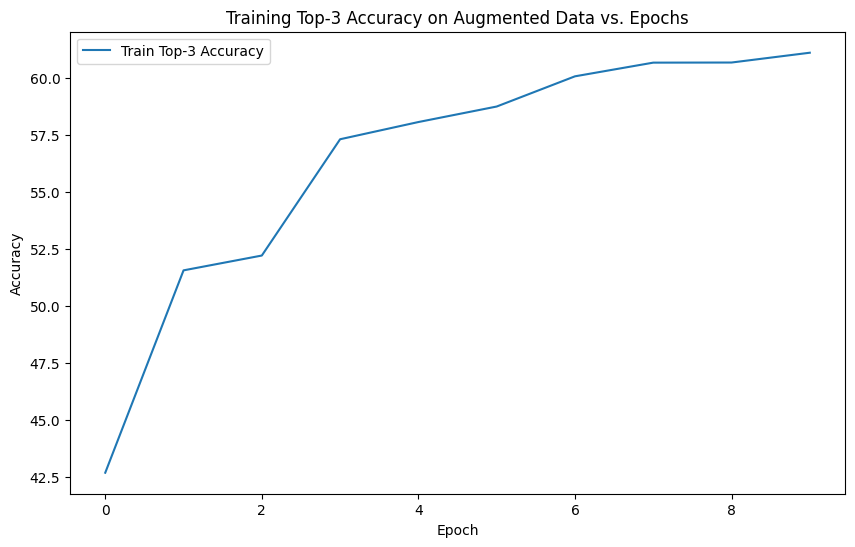

In [ ]:
# Plot top-3 accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_top3_accuracies, label='Train Top-3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Top-3 Accuracy on Augmented Data vs. Epochs')
plt.legend()
plt.show()

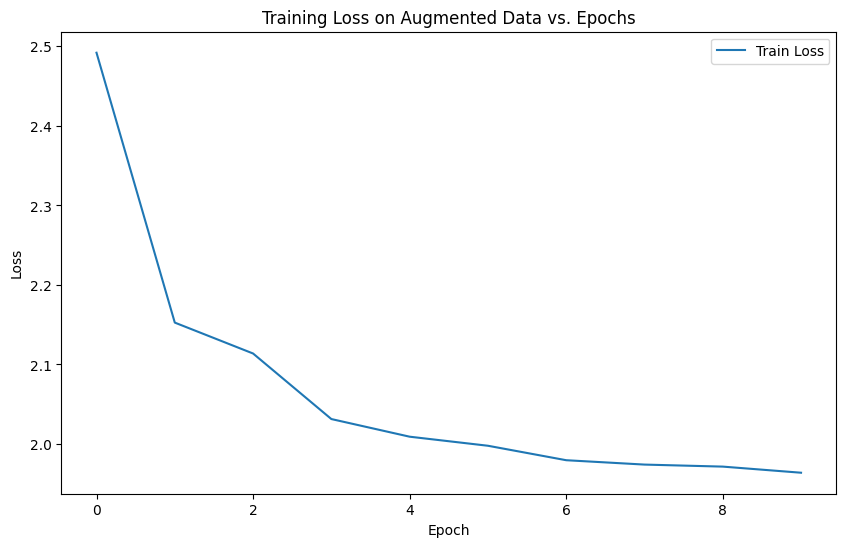

In [ ]:
# Plot training loss and test loss, accuracy, and top-3 accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss on Augmented Data vs. Epochs')
plt.legend()